In [389]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
import scipy as sp
import numpy as np

sns.set_theme(context='notebook', style='whitegrid', palette='tab10')

df_azioni = pd.read_parquet('datasets/azioni_partite_dati_derivati.parquet')
df_pacchi = pd.read_parquet('datasets/pacchi_e_vincite.parquet')

In [267]:
%%HTML
<link rel="stylesheet" type="text/css" href="style.css">

<p class="sub">167341 &mdash; Zorzi Luca</p>
<h1><b>Analisi sui dati del gioco televisivo "Affari Tuoi"</b></h1>
<p class="sub">10/07/2024 &mdash; Università degli Studi di Udine</p>

<h2><b>Il gioco in breve</b></h2>

<div class="container">
    <div class="left">
        <ul>
            <li>Ogni pacco contiene dei soldi, i premi nei pacchi aperti vengono persi</li>
            <li>Il "Dottore" conosce il contenuto dei pacchi</li>
            <li>Il "Dottore" può proporre un'offerta monetaria</li>
        </ul>
    </div>
    <div class="right">
        <img src="src/affari_tuoi.jpeg" alt="Gioco Affari Tuoi">
    </div>
</div>

<h2><b>Cosa vorrei scoprire?</b></h2>
<ol>
    <li>Ci sono pacchi più fortunati di altri?</li>
    <li>È possibile prevedere le offerte del dottore?</li>
    <li>È possibile scoprire in anticipo il premio del concorrente?</li>
    <li>Pacco vs Offerta: con cosa conviene vincere?</li>
</ol>

<div class="container">
<div class="left">
<h3><b>Raccolta dati</b></h3>
<ul>
<li><b>Periodo</b>: dal 12/02/2024 al 20/05/2024</li>
<li><b>Strumenti</b>: Software con GUI creato da me</li>
</ul>
<br>
<h3><b>Dataset</b></h3>
<ul>
    <b>Dati raccolti:</b>
    <li>Azioni di gioco e relativi stati</li>
    <li>Contenuto pacchi</li>
    <li>Vincita e tipo vincita</li>
    <b>Dati derivati:</b>
    <li>Premi rimasti in gioco dopo ogni azione</li>
    <li>Media premi rimasti dopo ogni azione</li>
    <li>Premio in mano al concorrente</li>
    <b>Dati mancanti ma interessanti:</b>
    <li>Budget Rai per il programma</li>
    <li>Prezzo giornaliero per le inserzioni</li>
    <li>Numero di inserzioni per puntata</li>
</ul>
</div>
<div class="right">
<img src="src/sw_data_entry.png" alt="Software per la raccolta dei dati">
</div>
</div>

<h2><b>1) Ci sono pacchi più fortunati di altri?</b></h2>
<p>Metriche per l'analisi:</p>
<ul>
    <li><b>Somma cumulativa</b> dei premi per ogni pacco</li>
    <li>Distrubuzione dei premi per ogni pacco</li>
</ul>

<h3><b>1) Ci sono pacchi più fortunati di altri?</b></h3>
<h4 class="sub"><b>Somma cumulativa dei premi nel tempo</b></p>

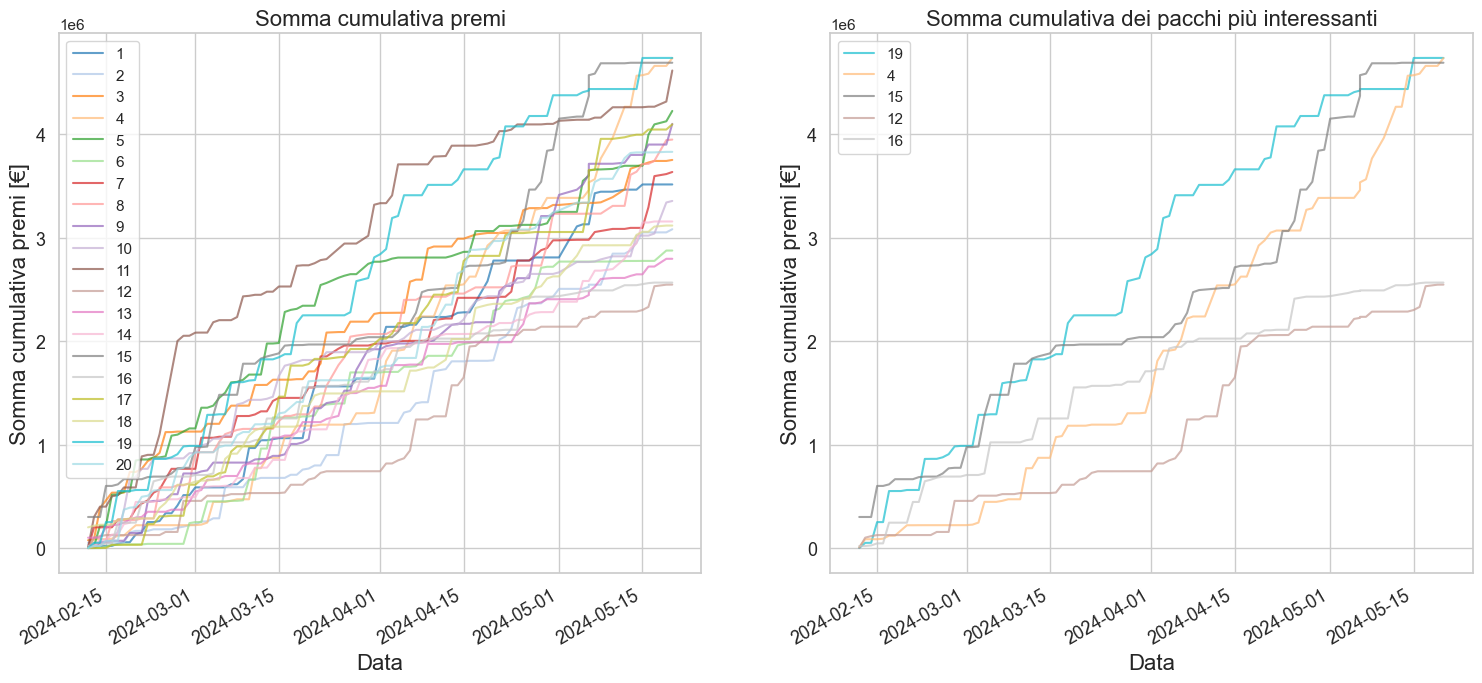

In [406]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7)) # Doppio grafico

selected_columns = [str(i) for i in range(1, 21)] # Nomi delle colonne contenenti i pacchi
df_selected_pacchi = df_pacchi.loc[:, selected_columns] # Seleziona le colonne con valori dei pacchi

somma_cumulativa_premi = pd.DataFrame(columns=selected_columns) # Dataset vuoto x salvare le somme
tmp_dict = {} # Riga temporanea

# Calcolo somma cumulativa
for i in range(len(df_selected_pacchi)):
    tmp_df = df_selected_pacchi.iloc[0:i+1] # Prendo le prime i+1 righe...
    for pacco in tmp_df:
        tmp_dict[pacco] = tmp_df[pacco].sum() # ... e ne calcolo la somma per ogni pacco

    somma_cumulativa_premi.loc[len(somma_cumulativa_premi)] = tmp_dict

# Setto la data come indice
somma_cumulativa_premi['Data'] = df_pacchi['Data']
somma_cumulativa_premi = somma_cumulativa_premi.set_index('Data')

# Plotto le somme cumulative
somma_cumulativa_premi.plot(kind='line', alpha=0.7, colormap='tab20', ax=ax1)
ax1.set_ylabel('Somma cumulativa premi [€]', fontsize=16)
ax1.set_xlabel('Data', fontsize=16)
ax1.tick_params(axis='both', labelsize=13)
ax1.set_title('Somma cumulativa premi', fontsize=16)

# Creo una colormap custom per rispettare i colori del primo grafico
colors = matplotlib.colormaps['tab20'].colors
cmap = []
cmap.append(colors[18])
cmap.append(colors[3])
cmap.append(colors[14])
cmap.append(colors[11])
cmap.append(colors[15])
cmap = LinearSegmentedColormap.from_list('4lines', cmap, N=5)

# Plotto i pacchi più interessanti
somma_cumulativa_premi[['19', '4', '15', '12', '16']].plot(kind='line', alpha=0.7, ax=ax2, colormap=cmap)
ax2.set_ylabel('Somma cumulativa premi [€]', fontsize=16)
ax2.set_xlabel('Data', fontsize=16)
ax2.tick_params(axis='both', labelsize=13)
ax2.set_title('Somma cumulativa dei pacchi più interessanti', fontsize=16)

plt.tight_layout() # Sistema il padding tra i subplot
plt.subplots_adjust(wspace=0.2) # Spazio tra i grafici
plt.show()


<h3><b>1) Ci sono pacchi più fortunati di altri?</b></h3>
<h4 class="sub"><b>Distribuzione dei premi nei pacchi</b></h4>

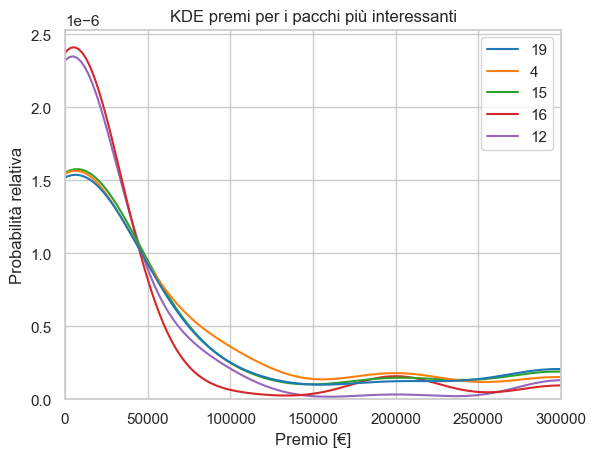

In [303]:
ax = sns.kdeplot(df_selected_pacchi[['19', '4', '15', '16', '12']])
ax.set_xlim(0, 300000)
ax.set_xlabel('Premio [€]')
ax.set_ylabel('Probabilità relativa')
ax.set_title('KDE premi per i pacchi più interessanti')
plt.show()

<h3><b>1) Ci sono pacchi più fortunati di altri?</b></h3>
<h4 class="sub"><b>Distribuzione dei premi nei pacchi</b></h4>

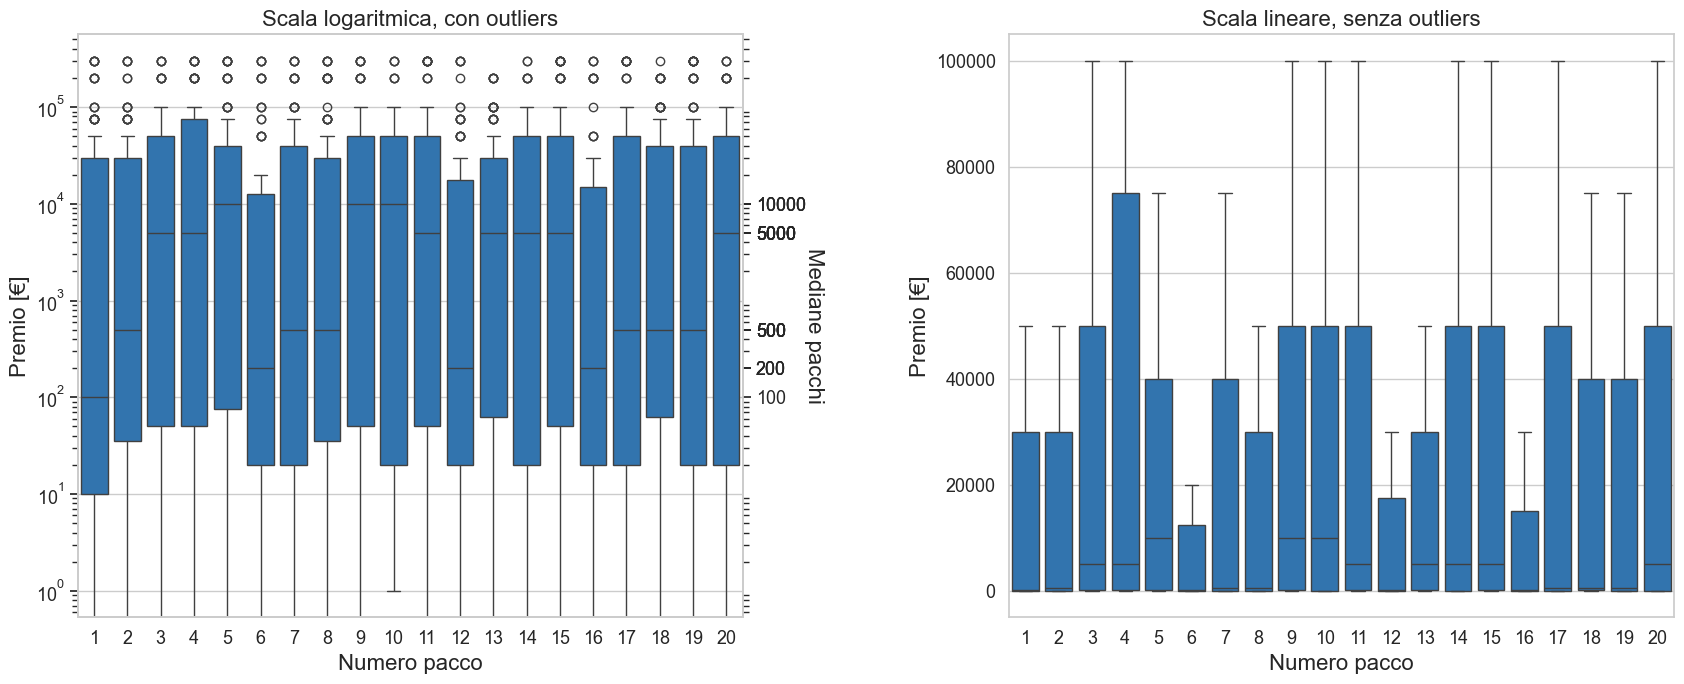

In [408]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7)) # Doppio grafico

color = (0.11372549019607843, 0.4588235294117647, 0.7647058823529411)

sns.boxplot(df_selected_pacchi, color=color, ax=ax1)
ax1.set_yscale('log')
ax1.set_xlabel('Numero pacco', fontsize=16)
ax1.set_ylabel('Premio [€]', fontsize=16)
ax1.tick_params(axis='both', labelsize=13)
ax1.set_title('Scala logaritmica, con outliers', fontsize=16)

# Aggiunta ticks personalizzati con le mediane su un secondo asse y
mediane = df_selected_pacchi.median()
y2 = ax1.twinx() # Gemello y con asse x comune
y2.set_yscale('log')
y2.set_yticks(list(mediane))
y2.set_yticklabels([f'{mediana:.0f}' for mediana in mediane])
y2.set_ylim(ax1.get_ylim())
y2.tick_params(axis='y', labelsize=13)
y2.grid(False)
y2.set_ylabel('Mediane pacchi', rotation=270, fontsize=16, labelpad=13)

# Boxplot scala lienare senza outliers
sns.boxplot(df_selected_pacchi, color=color, showfliers=False, ax=ax2)
ax2.set_xlabel('Numero pacco', fontsize=16)
ax2.set_ylabel('Premio [€]', fontsize=16)
ax2.tick_params(axis='both', labelsize=13)
ax2.set_title('Scala lineare, senza outliers', fontsize=16)


plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.show()

<h2><b>2) È possibile prevedere le offerte del dottore?</b></h2>
<p>Come arrivare al risultato:</p>
<ul>
    <li>Correlazione tra <b>media dei premi in gioco</b> e <b>valore delle offerte</b></li>
    <li>Previsione delle offerte del dottore tramite un modello di regressione lineare</li>
</ul>

In [271]:
# Tengo solo le righe in cui è stata fatta un'offerta
df_filtered = df_azioni.dropna(subset=['valOfferta'])
df_p_rimasti_offerte = df_filtered[['valOfferta', 'statoOfferta', 'premiRimasti', 'mediaPremiRimasti', 'premioManoConcorrente']]

pearson = sp.stats.pearsonr(df_p_rimasti_offerte['mediaPremiRimasti'], df_p_rimasti_offerte['valOfferta'])
spearman = sp.stats.spearmanr(df_p_rimasti_offerte['mediaPremiRimasti'], df_p_rimasti_offerte['valOfferta'])
kendall = sp.stats.kendalltau(df_p_rimasti_offerte['mediaPremiRimasti'], df_p_rimasti_offerte['valOfferta'])

print(f'Pearson: {pearson[0]:.4f} p={pearson[1]:.2e}')
print(f'Spearman: {spearman[0]:.4f} p={spearman[1]:.2e}')
print(f'Kendall:  {kendall[0]:.4f} p={kendall[1]:.2e}')

Pearson: 0.8907 p=3.55e-132
Spearman: 0.8746 p=1.57e-121
Kendall:  0.7145 p=4.71e-94


<h3><b>2) È possibile prevedere le offerte del dottore?</b></h3>
<h4 class="sub"><b>Coefficienti di correlazione</b></h4>
<p>
    Correlazione tra <b>media dei premi in gioco</b> e <b>valore delle offerte</b> secondo i coefficienti di <b>Pearson</b>, <b>Spearman</b> e <b>Kendall</b>:
    <ul>
        <li><b>Pearson</b>: <div class="num">0.8907 p=3.55e-132</div></li>
        <li><b>Spearman</b>: <div class="num">0.8746 p=1.57e-121</div></li>
        <li><b>Kendall</b>: <div class="num">0.7145 p=4.71e-94</div></li>
    </ul>
</p>
<br>
<p>Correlazione positiva con bassa probabilità che sia dovuta al caso.</p>

<h3><b>2) È possibile prevedere le offerte del dottore?</b></h3>
<h4 class="sub"><b>Retta di regressione</b></h4>

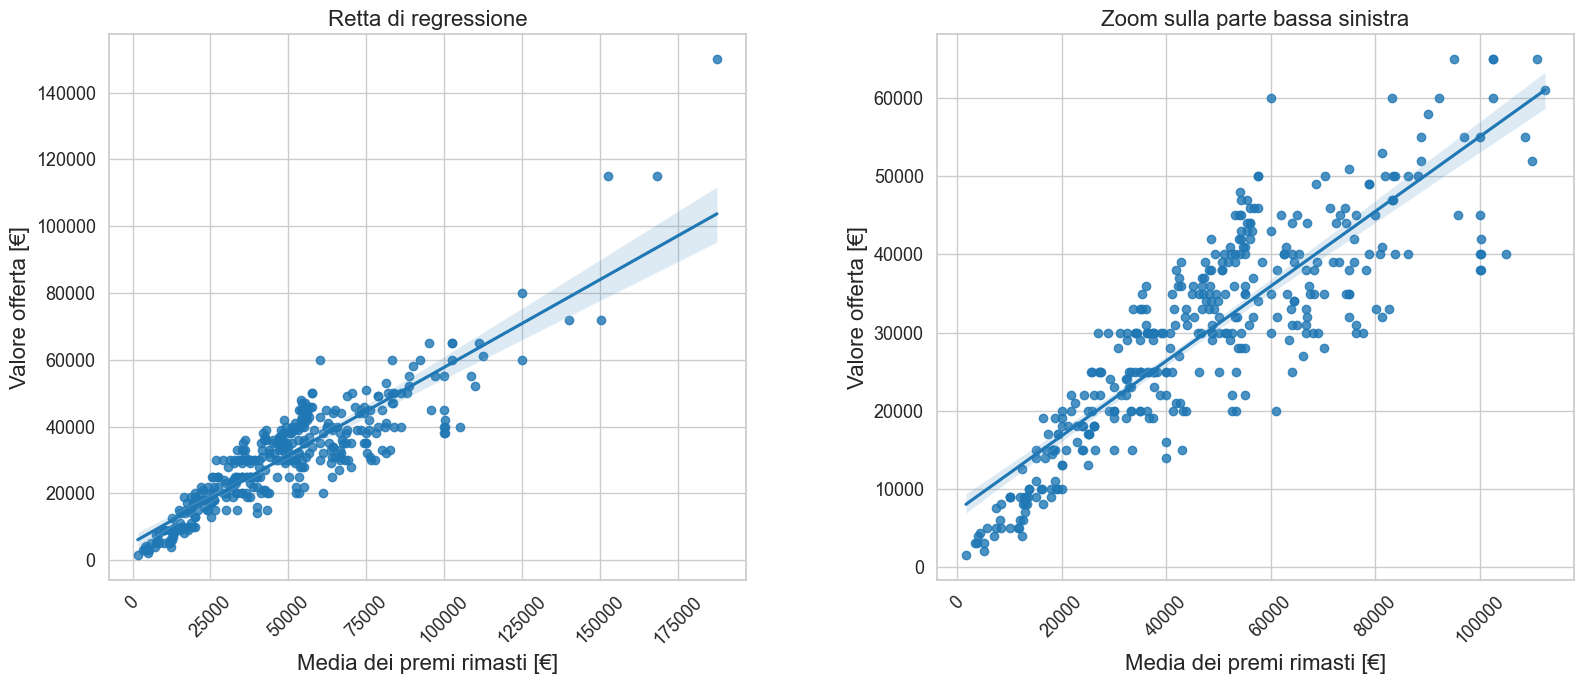

In [411]:
# Creazione del grafico principale e del grafico zoom
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Grafico principale
sns.regplot(data=df_p_rimasti_offerte, x='mediaPremiRimasti', y='valOfferta', ax=ax1)
ax1.set_title('Retta di regressione', fontsize=16)
ax1.set_xlabel('Media dei premi rimasti [€]', fontsize=16)
ax1.set_ylabel('Valore offerta [€]', fontsize=16)
ax1.tick_params(axis='both', labelsize=13)
ax1.tick_params(axis='x', rotation=45)

# Grafico ingrandito (zoom)
zoom_data = df_p_rimasti_offerte[df_p_rimasti_offerte['mediaPremiRimasti'] <= 120000]

sns.regplot(data=zoom_data, x='mediaPremiRimasti', y='valOfferta', ax=ax2)
ax2.set_title('Zoom sulla parte bassa sinistra', fontsize=16)
ax2.set_xlabel('Media dei premi rimasti [€]', fontsize=16)
ax2.set_ylabel('Valore offerta [€]', fontsize=16)
ax2.tick_params(axis='both', labelsize=13)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()

<h3><b>2) È possibile prevedere le offerte del dottore?</b></h3>
<h4 class="sub"><b>Modello di regressione lineare</b></h4>

In [273]:
# -------------- MODELLO 2D (Media premi -> offerta) --------------

# Predictors (X, medie premi in gioco) e Results (Y, offerte dottore)
X_2d = df_p_rimasti_offerte[['mediaPremiRimasti']]
Y_2d = df_p_rimasti_offerte['valOfferta']

# Divido il dataset in una parte di train e una parte di test (predizioni)
# test_size=percentuale dati da dedicare al test, random_state=seme per la riproducibilità dell'esperimento
X_train_2d, X_test_2d, Y_train_2d, Y_test_2d = train_test_split(X_2d, Y_2d, test_size=0.2, random_state=42)


# Allenamento del modello
model_2d = LinearRegression().fit(X_train_2d, Y_train_2d)

# Predizione sui dati di test
Y_pred_2d = model_2d.predict(X_test_2d)

# Valutazione del modello dopo le predizioni
mae_2d = mean_absolute_error(Y_test_2d, Y_pred_2d)
mse_2d = mean_squared_error(Y_test_2d, Y_pred_2d)
r2_2d = r2_score(Y_test_2d, Y_pred_2d)

print('Mean Absolute Error (MAE):', mae_2d)
print('Root Mean Squared Error:', sqrt(mse_2d))
print('R^2:', r2_2d)


Mean Absolute Error (MAE): 5933.614548913852
Root Mean Squared Error: 7618.827203575449
R^2: 0.7262256804525435


<p>
    Principali metriche per la valutazione di un modello di <b>regressione lineare</b>:
    <ul>
        <li><b>R<sup>2</sup></b>: <div class="num">0.726</div></li>
        <li><b>Mean Absolute Error (MAE)</b>: <div class="num">5933.6[€]</div></li>
        <li><b>Root Mean Squared Error (RMSE)</b>: <div class="num">7618.8[€]</div></li>
    </ul>    
</p>

<h2><b>3) È possibile scoprire in anticipo il premio del concorrente?</b></h2>
<p>Come arrivare al risultato:</p>
<ul>
    <li>Utilizzo dei risultati precedentemente visti</li>
    <li>Si prova ad aggiungere il premio in mano al concorrente come variabile dipendente, ponendo offerta e media dei premi come variabili indipendenti</li>
    <li>Valutazione della correlazione e allenamento di un modello di regressione lineare</li>
</ul>

<h3><b>3) È possibile scoprire in anticipo il premio del concorrente?</b></h3>
<h4 class="sub"><b>Correlazione tra offerte, media premi rimasti e premio concorrente</b></h4>

In [274]:
# Matrice di correlazione di Pearson
correlazione_pearson = df_p_rimasti_offerte[['mediaPremiRimasti', 'valOfferta', 'premioManoConcorrente']].corr(method='pearson')
print('Matrice di correlazione di Pearson:')
print(correlazione_pearson)

# Matrice di correlazione di Spearman
correlazione_spearman = df_p_rimasti_offerte[['mediaPremiRimasti', 'valOfferta', 'premioManoConcorrente']].corr(method='spearman')
print('Matrice di correlazione di Spearman:')
print(correlazione_spearman)

# Matrice di correlazione di Kendall
correlazione_kendall = df_p_rimasti_offerte[['mediaPremiRimasti', 'valOfferta', 'premioManoConcorrente']].corr(method='kendall')
print('Matrice di correlazione di Kendall:')
print(correlazione_kendall)

Matrice di correlazione di Pearson:
                       mediaPremiRimasti  valOfferta  premioManoConcorrente
mediaPremiRimasti               1.000000    0.890711               0.306791
valOfferta                      0.890711    1.000000               0.349542
premioManoConcorrente           0.306791    0.349542               1.000000
Matrice di correlazione di Spearman:
                       mediaPremiRimasti  valOfferta  premioManoConcorrente
mediaPremiRimasti               1.000000    0.874605               0.115496
valOfferta                      0.874605    1.000000               0.190946
premioManoConcorrente           0.115496    0.190946               1.000000
Matrice di correlazione di Kendall:
                       mediaPremiRimasti  valOfferta  premioManoConcorrente
mediaPremiRimasti               1.000000    0.714516               0.085078
valOfferta                      0.714516    1.000000               0.134937
premioManoConcorrente           0.085078    0.134937   

<table>
    <tr>
        <th colspan="2"></th>
        <th>Premio concorrente</th>
    </tr>
    <!-- Pearson -->
    <tr>
        <th rowspan="2">Pearson</th>
        <th>Valore offerta</th>
        <td class="text-num">0.3495</td>
    </tr>
    <tr>
        <th>Media premi in gioco</th>
        <td class="text-num">0.3068</td>
    </tr>
    <!-- Spearman -->
    <tr>
        <th rowspan="2">Spearman</th>
        <th>Valore offerta</th>
        <td class="text-num">0.1909</td>
    </tr>
    <tr>
        <th>Media premi in gioco</th>
        <td class="text-num">0.1155</td>
    </tr>
    <!-- Kendall -->
    <tr>
        <th rowspan="2">Kendall</th>
        <th>Valore offerta</th>
        <td class="text-num">0.1349</td>
    </tr>
    <tr>
        <th>Media premi in gioco</th>
        <td class="text-num">0.0850</td>
    </tr>
</table>

<h3><b>3) È possibile scoprire in anticipo il premio del concorrente?</b></h3>
<h4 class="sub"><b>Modello di regressione lineare</b></h4>

In [417]:
# -------------- MODELLO 3D (Media premi, offerta -> premio concorrente) --------------

# Predictors (X, media premi e offerta dottore) e Results (Y, premio concorrente)
X_3d = df_p_rimasti_offerte[['mediaPremiRimasti', 'valOfferta']]
Y_3d = df_p_rimasti_offerte['premioManoConcorrente']

# Divido il dataset in una parte di train e una parte di test (predizioni)
# test_size=percentuale dataset per test, random_state=seme per la riproducibilità dell'esperimento
X_train_3d, X_test_3d, Y_train_3d, Y_test_3d = train_test_split(X_3d, Y_3d, test_size=0.2, random_state=42)


# Allenamento del modello
model_3d = LinearRegression().fit(X_train_3d, Y_train_3d)

# Predizione sui dati di test
Y_pred_3d = model_3d.predict(X_test_3d)

# Valutazione del modello dopo le predizioni
mae_3d = mean_absolute_error(Y_test_3d, Y_pred_3d)
mse_3d = mean_squared_error(Y_test_3d, Y_pred_3d)
r2_3d = r2_score(Y_test_3d, Y_pred_3d)

print('Mean Absolute Error (MAE):', mae_3d)
print('Root Mean Squared Error (RMSE):', sqrt(mse_3d))
print('R^2:', r2_3d)


Mean Absolute Error (MAE): 64008.08989994087
Root Mean Squared Error (RMSE): 90903.56681757647
R^2: -0.010817338964718148


<p>
    Principali metriche per la valutazione di un modello di <b>regressione lineare</b>:
    <ul>
        <li><b>R<sup>2</sup></b>: <div class="num">-0.011</div></li>
        <li><b>Mean Absolute Error (MAE)</b>: <div class="num">64008.1[€]</div></li>
        <li><b>Root Mean Squared Error (RMSE)</b>: <div class="num">90903.6[€]</div></li>
    </ul>    
</p>

<h3><b>4) Pacco vs Offerta: con cosa conviene vincere?</b></h3>
<h4 class="sub"><b>Analisi distribuzione delle vincite</b></h4>

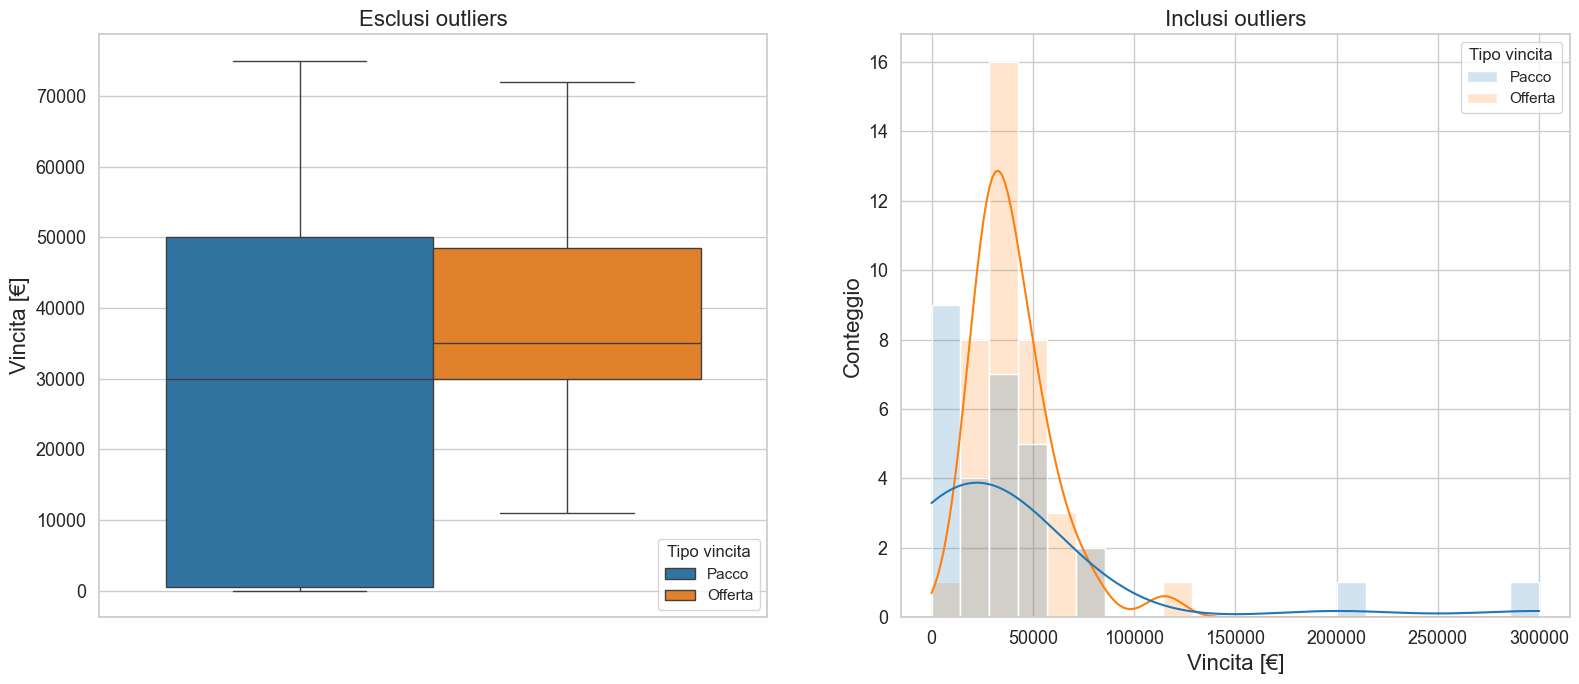

In [416]:
# Seleziono tutte le vincite, il loro tipo e ripulisco i dati
df_vincite = df_pacchi[['Vincita', 'Tipo vincita']].copy()
df_vincite.dropna(inplace=True)
df_vincite.drop(df_vincite[df_vincite['Tipo vincita'] == 'Regione fortunata'].index, inplace=True)
df_vincite.reset_index(inplace=True, drop=True)

# Doppio grafico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Boxplot con outliers esclusi per motivi di spazio
sns.boxplot(df_vincite, y='Vincita', hue='Tipo vincita', showfliers=False, ax=ax1)
sns.move_legend(ax1, 'lower right')
ax1.set_ylabel('Vincita [€]', fontsize=16)
ax1.set_title('Esclusi outliers', fontsize=16)
ax1.tick_params(axis='both', labelsize=13)

# Istogramma con la distribuzione delle vincite per tipo
sns.histplot(df_vincite, x='Vincita', kde=True, hue='Tipo vincita', alpha=0.2, ax=ax2)
ax2.set_xlabel('Vincita [€]', fontsize=16)
ax2.set_ylabel('Conteggio', fontsize=16)
ax2.set_title('Inclusi outliers', fontsize=16)
ax2.tick_params(axis='both', labelsize=13)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

<h3><b>Conclusioni</b></h3>
<h4 class="sub"><b>Cosa abbiamo scoperto dalle analisi?</b></h4>
<br>
<ol>
    <b>
    <li>Ci sono pacchi più fortunati di altri?</li>
    <ul style="list-style-type:none;">
        <li class="sub">A breve termine sembrerebbe di sì.</li>
    </ul>
    <li>È possibile prevedere le offerte del dottore?</li>
    <ul style="list-style-type:none;">
        <li class="sub">Sì, con abbastanza accuratezza.</li>
    </ul>
    <li>È possibile scoprire in anticipo il premio del concorrente?</li>
    <ul style="list-style-type:none;">
        <li class="sub">Non con i metodi utilizzati.</li>
    </ul>
    <li>Pacco vs Offerta: con cosa conviene vincere?</li>
    <ul style="list-style-type:none;">
        <li class="sub">L'offerta è meno proficua ma più sicura.</li>
    </ul>
    </b>
</ol>